# out_fiberID
* 기존변수 + u-g,g-r,r-i,i-z만 추가변수로 사용
* 각 mag에서 max인 filter 변수추가
* fiber_ID를 제외하고 진행해봄
* 제출결과 : 0.3793087274 
-> fiberID를 제외해서 0.02상승

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
import lightgbm as lgb

C:\Users\starl\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# #colab용
# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/')

In [4]:
# path = "/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/data/" #colab
path = "./data/" #local
train_df = pd.read_csv(path+'train.csv',index_col=0)
test_df = pd.read_csv(path+'test.csv',index_col=0)
sample_submission_df = pd.read_csv(path+'sample_submission.csv',index_col=0)
pd.options.display.max_columns = 30

## DATA Setting

In [5]:
column_number = {}
number_columns = {}
for i, column in enumerate(sample_submission_df.columns):
    column_number[column] = i
    number_columns[i] = column
    
    
def to_number(x, dic):
    return dic[x]

train_df['type_num'] = train_df['type'].apply(lambda x: to_number(x, column_number))


In [6]:
def add_minus_feature_all(data,test = False):
    '''
    combination으로 모든 변수들의 조합에 대해서 컬럼생성 
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 64개로 증가
    '''
    from itertools import combinations
    n = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
        data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for combi in list(combinations(selected,2)):
            name_1st = str.split(combi[0],'_')[1]
            name_2nd = str.split(combi[1],'_')[1]
            data[mag+"_"+name_1st+"-"+name_2nd] = data[combi[0]]-data[combi[1]]
        n=count
    return data

In [7]:
def add_minus_feature(data,test = False):
    '''
    근접변수에 대해서만 컬럼생성 ex) 'fiberMag_u-g', 'fiberMag_g-r', 'fiberMag_r-i', 'fiberMag_i-z'
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 38개로 증가 
    '''
    from itertools import combinations
    n = 0
    m = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
        data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for i in range(0,len(selected)):        
            if i>0: 
                name_1st = str.split(m,'_')[1]
                name_2nd = str.split(selected[i],'_')[1]
                data[mag+"_"+name_1st+"-"+name_2nd] = data[m]-data[selected[i]]
            m = selected[i]    
        n=count
    return data

In [13]:
train_df = add_minus_feature_all(train_df)
test_df = add_minus_feature_all(test_df,True)

C:\Users\starl\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


In [14]:
train_df.shape,test_df.shape

((199991, 67), (10009, 65))

In [15]:
train_df.columns

Index(['type', 'fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
       'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i',
       'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i',
       'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z', 'type_num', 'psfMag_MAX', 'psfMag_u-g', 'psfMag_g-r',
       'psfMag_r-i', 'psfMag_i-z', 'fiberMag_MAX', 'fiberMag_u-g',
       'fiberMag_g-r', 'fiberMag_r-i', 'fiberMag_i-z', 'petroMag_MAX',
       'petroMag_u-g', 'petroMag_g-r', 'petroMag_r-i', 'petroMag_i-z',
       'modelMag_MAX', 'modelMag_u-g', 'modelMag_g-r', 'modelMag_r-i',
       'modelMag_i-z', 'psfMag_u-r', 'psfMag_u-i', 'psfMag_u-z', 'psfMag_g-i',
       'psfMag_g-z', 'psfMag_r-z', 'fiberMag_u-r', 'fiberMag_u-i',
       'fiberMag_u-z', 'fiberMag_g-i', 'fiberMag_g-z', 'fiberMag_r-z',
       'petroMag_u-r', 'petroMag_u-i', 'petroMag_u-z', 'petroMag_g-i',
       'petroMag_g-z', 'petroMag_r-z', 'modelMag_u-r',

In [16]:
def label_encode(data):
    '''
    각 mag에서 가장 높은값의 filter를 labelencoding 
    '''
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    taget_cols = ['psfMag_MAX','fiberMag_MAX','petroMag_MAX','modelMag_MAX']
    for col in taget_cols:
        data[col] = le.fit_transform(data[col])
    return data

In [17]:
train_df = label_encode(train_df)
test_df = label_encode(test_df)

In [19]:
train_X = train_df.drop(columns=['type', 'type_num','fiberID'], axis=1)
train_y = train_df['type_num']
test_X = test_df.drop(columns = ['fiberID'])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42,stratify = train_y)

In [46]:
y_train.value_counts()

8     34776
6     26143
18    15232
15    10241
4     10232
10     9625
5      9450
13     4992
11     4606
1      4554
7      3258
14     2280
3      1793
0      1512
16      808
2       350
9        89
17       43
12        9
Name: type_num, dtype: int64

In [45]:
y_test.value_counts()

8     14904
6     11204
18     6528
15     4389
4      4386
10     4125
5      4050
13     2140
11     1974
1      1952
7      1396
14      977
3       769
0       648
16      346
2       150
9        38
17       18
12        4
Name: type_num, dtype: int64

In [21]:
train_ds = lgb.Dataset(X_train, label = y_train)
test_ds = lgb.Dataset(X_test, label = y_test) 

In [22]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': train_y.nunique(),
    'metric': {'multi_logloss','multi_logloss'},
    'num_leaves': 25,
    'learning_rate': 0.005,
    'max_depth' : 12,
    'random_state' : 42
}

## Modeling

In [23]:
evaluation_results = {}
lgmb_model = lgb.train(params, train_ds,num_boost_round= 20000, 
                       valid_sets = [train_ds,test_ds], valid_names=['Train', 'Test'],
                       evals_result=evaluation_results,
                       verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	Train's multi_logloss: 1.28915	Test's multi_logloss: 1.30665
[200]	Train's multi_logloss: 0.90698	Test's multi_logloss: 0.931746
[300]	Train's multi_logloss: 0.696606	Test's multi_logloss: 0.726893
[400]	Train's multi_logloss: 0.570231	Test's multi_logloss: 0.604999
[500]	Train's multi_logloss: 0.490545	Test's multi_logloss: 0.529431
[600]	Train's multi_logloss: 0.438927	Test's multi_logloss: 0.481765
[700]	Train's multi_logloss: 0.403848	Test's multi_logloss: 0.450448
[800]	Train's multi_logloss: 0.378803	Test's multi_logloss: 0.42904
[900]	Train's multi_logloss: 0.360637	Test's multi_logloss: 0.414541
[1000]	Train's multi_logloss: 0.3465	Test's multi_logloss: 0.404097
[1100]	Train's multi_logloss: 0.335258	Test's multi_logloss: 0.396553
[1200]	Train's multi_logloss: 0.325937	Test's multi_logloss: 0.391005
[1300]	Train's multi_logloss: 0.318143	Test's multi_logloss: 0.386845
[1400]	Train's multi_logloss: 0.311355	Test

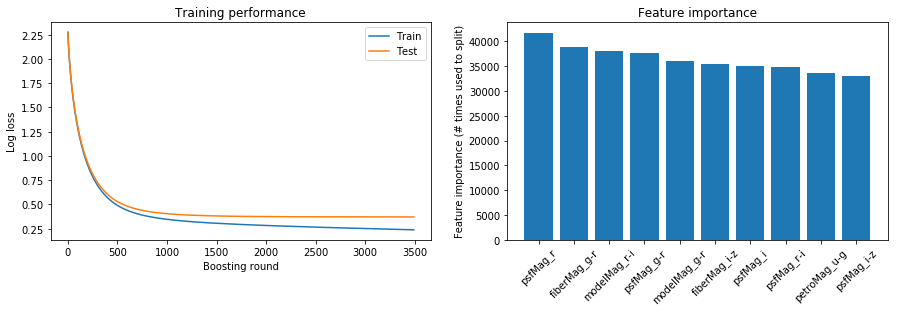

In [24]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['multi_logloss'], label='Train')
axs[0].plot(evaluation_results['Test']['multi_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgmb_model.feature_name(), 
                            'importance': lgmb_model.feature_importance()}).sort_values('importance', ascending=False).head(10)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')
plt.xticks(rotation=45)

plt.show()

In [25]:
train_y_pred = lgmb_model.predict(X_test)
real_y_pred = lgmb_model.predict(test_X)

In [26]:
train_y_pred.shape

(59998, 19)

In [27]:
#log_loss
log_loss(y_test,train_y_pred,labels= list(set(y_test)))

0.37081673715894764

In [28]:
lgmb_model.feature_importance()

array([24471, 31983, 41756, 35005, 29103, 26341, 26245, 28814, 31602,
       24024, 25719, 18686, 23223, 29347, 23489, 26089, 22207, 20816,
       21506, 27953,   808, 31642, 37703, 34807, 33036,  1054, 32936,
       38854, 31029, 35357,  1800, 33661, 33002, 28831, 31651,   865,
       31335, 36088, 37984, 32688, 23894, 17370, 13342, 21292, 17036,
       19562, 21402, 15513, 16121, 21140, 16636, 26308, 20419, 19046,
       19354, 18806, 16994, 18184, 21542, 17345, 14842, 21453, 15014,
       23116])

### feature_importance

In [31]:
pi_df = pd.DataFrame(lgmb_model.feature_importance(), index= train_X.columns,columns= ['importance']).sort_values('importance',ascending = False)
pi_df.head(10)

,importance
psfMag_r,41756
fiberMag_g-r,38854
modelMag_r-i,37984
psfMag_g-r,37703
modelMag_g-r,36088
fiberMag_i-z,35357
psfMag_i,35005
psfMag_r-i,34807
petroMag_u-g,33661
psfMag_i-z,33036


### 예측결과에 대해
* 12번이 모두 6번으로 몰림
중간예측 : 0(STAR_WHITE_DWARF-2160),2(STAR_BROWN_DWARF-500),7(SERENDIPITY_DISTANT-4654),11(ROSAT_D-6580)
망한예측 : 12(STAR_PN-13),17(SERENDIPITY_MANUAL-61)

In [32]:
cm_result = pd.DataFrame(confusion_matrix(y_test,np.argmax(train_y_pred,axis = 1)))

In [36]:
number_columns

{0: 'STAR_WHITE_DWARF',
 1: 'STAR_CATY_VAR',
 2: 'STAR_BROWN_DWARF',
 3: 'SERENDIPITY_RED',
 4: 'REDDEN_STD',
 5: 'STAR_BHB',
 6: 'GALAXY',
 7: 'SERENDIPITY_DISTANT',
 8: 'QSO',
 9: 'SKY',
 10: 'STAR_RED_DWARF',
 11: 'ROSAT_D',
 12: 'STAR_PN',
 13: 'SERENDIPITY_FIRST',
 14: 'STAR_CARBON',
 15: 'SPECTROPHOTO_STD',
 16: 'STAR_SUB_DWARF',
 17: 'SERENDIPITY_MANUAL',
 18: 'SERENDIPITY_BLUE'}

In [37]:
train_df.type.value_counts()

QSO                    49680
GALAXY                 37347
SERENDIPITY_BLUE       21760
SPECTROPHOTO_STD       14630
REDDEN_STD             14618
STAR_RED_DWARF         13750
STAR_BHB               13500
SERENDIPITY_FIRST       7132
ROSAT_D                 6580
STAR_CATY_VAR           6506
SERENDIPITY_DISTANT     4654
STAR_CARBON             3257
SERENDIPITY_RED         2562
STAR_WHITE_DWARF        2160
STAR_SUB_DWARF          1154
STAR_BROWN_DWARF         500
SKY                      127
SERENDIPITY_MANUAL        61
STAR_PN                   13
Name: type, dtype: int64

In [33]:
cm_result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,302,0,0,0,16,61,1,125,68,0,0,14,0,1,21,8,0,0,31
1,1,1881,0,0,0,0,1,2,17,0,2,1,0,0,0,0,5,0,42
2,0,0,69,74,0,0,0,0,0,1,6,0,0,0,0,0,0,0,0
3,0,0,34,650,0,0,0,0,0,2,82,1,0,0,0,0,0,0,0
4,2,0,0,0,4244,32,1,0,11,0,0,10,0,0,0,86,0,0,0
5,27,0,0,0,148,3691,3,47,46,0,0,1,0,0,0,78,0,0,9
6,5,14,0,0,8,1,10946,3,72,1,0,52,0,79,14,8,0,0,1
7,187,0,0,0,0,205,0,725,19,0,0,1,0,0,0,1,0,0,258
8,9,9,1,7,32,253,108,31,12896,1,11,179,0,52,79,7,11,0,1218
9,0,0,0,0,0,0,2,0,5,31,0,0,0,0,0,0,0,0,0


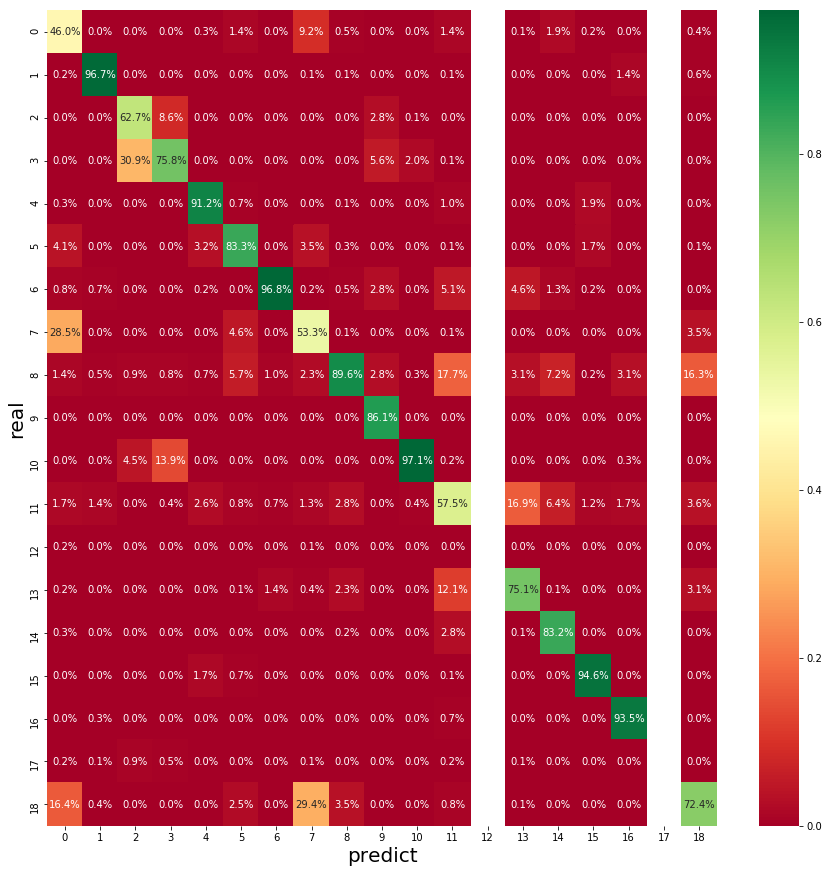

In [34]:
plt.figure(figsize =(15,15))
sns.heatmap(cm_result/np.sum(cm_result),annot = True, cmap ='RdYlGn',fmt='.1%')
plt.ylabel("real",fontsize=20)
plt.xlabel("predict",fontsize=20)
plt.show()

# REAL

In [40]:
train_ds = lgb.Dataset(train_X, label = train_y)

In [41]:
lgmb_model = lgb.train(params, train_ds,num_boost_round= 2000, verbose_eval=100)

In [42]:
y_pred = lgmb_model.predict(test_X)

In [43]:
y_pred

array([[3.13859208e-05, 8.83793425e-05, 2.51444171e-04, ...,
        2.22754088e-05, 1.63603700e-05, 2.78270038e-04],
       [1.35294734e-04, 2.82114471e-04, 1.99011308e-05, ...,
        4.34515991e-05, 1.42086341e-05, 9.45526773e-04],
       [8.80199945e-05, 3.21557773e-05, 1.86147928e-06, ...,
        4.04619993e-06, 8.94563031e-07, 8.77694872e-05],
       ...,
       [2.39358811e-04, 5.84679872e-04, 1.72932332e-05, ...,
        3.75893943e-05, 2.59392197e-06, 8.17155457e-02],
       [9.81027227e-06, 1.65461562e-05, 1.10090950e-06, ...,
        2.39298926e-06, 4.00333965e-07, 1.01326984e-03],
       [2.27134309e-04, 1.52210215e-05, 1.16973500e-06, ...,
        2.54259165e-06, 1.61755826e-07, 1.19144849e-04]])

In [44]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission_df.columns, index=sample_submission_df.index)
submission.to_csv('./submisson/submission.csv', index=True)